In [19]:
import numpy as np
import random

**Funcion que se va a minimizar (encontrar el minimo)**

In [20]:
def funcion_objetivo(x):
    """
    Función que se desea minimizar. En este caso: f(x) = x^2
    """
    return x[0] ** 2

**Clase para representar un murcielago, y los metodos del murcielago**

In [21]:
class Murcielago:
    def __init__(self, dim, lim_inf, lim_sup, frecuencia_min, frecuencia_max, volumen, pulso):
        """
        Inicializa un murciélago con posición, velocidad, frecuencia, volumen y pulso.
        """
        self.posicion = np.random.uniform(lim_inf, lim_sup, dim)
        self.velocidad = np.zeros(dim)
        self.frecuencia = 0.0
        self.volumen = volumen
        self.pulso = pulso
        self.aptitud = funcion_objetivo(self.posicion)

    def actualizar_frecuencia(self, frecuencia_min, frecuencia_max):
        self.frecuencia = frecuencia_min + (frecuencia_max - frecuencia_min) * random.random()

    def actualizar_velocidad(self, mejor_pos):
        self.velocidad += (self.posicion - mejor_pos) * self.frecuencia

    def mover(self, lim_inf, lim_sup):
        nueva_pos = self.posicion + self.velocidad
        self.posicion = np.clip(nueva_pos, lim_inf, lim_sup)

    def salto_local(self, mejor_pos):
        self.posicion = mejor_pos + 0.001 * np.random.randn(len(self.posicion))

**Algoritmo de optimización.**

In [22]:
class AlgoritmoMurcielago:
    def __init__(self, n_murcielagos, n_iteraciones, dim, lim_inf, lim_sup,
                 frecuencia_min, frecuencia_max, tasa_pulso, volumen_inicial):
        """
        Inicializa el algoritmo con parámetros globales y crea la población.
        """
        self.n_murcielagos = n_murcielagos  # cantidad de murciélagos que tendrá el algoritmo
        self.n_iteraciones = n_iteraciones  # número de veces que se va a repetir la búsqueda
        self.dim = dim  # número de dimensiones en las que se va a optimizar (cantidad de variables)
        self.lim_inf = lim_inf  # límite inferior del rango de búsqueda (por ejemplo -10)
        self.lim_sup = lim_sup  # límite superior del rango de búsqueda (por ejemplo 10)
        self.frecuencia_min = frecuencia_min  # frecuencia mínima utilizada para calcular la velocidad
        self.frecuencia_max = frecuencia_max  # frecuencia máxima utilizada para calcular la velocidad
        self.tasa_pulso = tasa_pulso  # probabilidad inicial de emitir un pulso; se usa para decidir si hace un salto local
        self.volumen_inicial = volumen_inicial  # qué tan fuerte es el sonido emitido, afecta la aceptación de nuevas soluciones


        self.murcielagos = []
        self.mejor_pos = None
        self.mejor_valor = float('inf')
        self.historial = []

    def inicializar_poblacion(self):
        for _ in range(self.n_murcielagos):
            mur = Murcielago(self.dim, self.lim_inf, self.lim_sup,
                             self.frecuencia_min, self.frecuencia_max,
                             self.volumen_inicial, self.tasa_pulso)
            self.murcielagos.append(mur)
            if mur.aptitud < self.mejor_valor:
                self.mejor_pos = mur.posicion.copy()
                self.mejor_valor = mur.aptitud

    def evaluar_murcielago(self, murciélago):
        valor = funcion_objetivo(murciélago.posicion)
        return valor

    def actualizar_mejor(self, murciélago, valor):
        if valor < self.mejor_valor:
            self.mejor_valor = valor
            self.mejor_pos = murciélago.posicion.copy()

    def ejecutar(self):
      # 1. Inicializa la población de murciélagos con posiciones, frecuencias y aptitudes
      self.inicializar_poblacion()

      # 2. Repite el proceso el número de iteraciones definida
      for t in range(self.n_iteraciones):

          # 3. se recore cada murcielago
          for mur in self.murcielagos:

              # 3.1. Actualiza la frecuencia del murciélago dentro del rango dado.
              # Por ejemplo, si frecuencia_min = 0 y frecuencia_max = 2, puede quedar en 1.27
              mur.actualizar_frecuencia(self.frecuencia_min, self.frecuencia_max)

              # 3.2. Usa la frecuencia para actualizar su velocidad, acercándose a la mejor posición global
              mur.actualizar_velocidad(self.mejor_pos)

              # 3.3. Con la nueva velocidad, actualiza su posición dentro de los límites dados
              mur.mover(self.lim_inf, self.lim_sup)

              # 3.4. Con probabilidad baja al inicio, decide si hace un salto local
              # Por ejemplo, si pulso = 0.2 y random da 0.6, entonces hace salto_local
              if random.random() > mur.pulso:
                  mur.salto_local(self.mejor_pos)

              # 3.5. Evalúa qué tan buena es la nueva posición
              valor = self.evaluar_murcielago(mur)

              # 3.6. Si la nueva posición es mejor (menor valor) y además pasa un filtro aleatorio,
              # acepta el movimiento y actualiza volumen y pulso
              if (valor <= mur.aptitud) and (random.random() < mur.volumen):
                  mur.aptitud = valor  # guarda la nueva mejor aptitud local
                  mur.volumen *= 0.9   # reduce el volumen para explorar menos lejos, por ejemplo: 1.0 → 0.9
                  mur.pulso = self.tasa_pulso * (1 - np.exp(-0.1 * t))
                  # esta fórmula hace que el pulso aumente con el tiempo
                  # por ejemplo, si tasa_pulso = 0.9, al principio es muy baja (0.08) pero después crece (→ 0.7, → 0.88...)

              # 3.7. Actualiza la mejor solución global si esta es la mejor encontrada hasta ahora
              self.actualizar_mejor(mur, valor)

          # 4. Guarda el valor de la mejor posición (en la dimensión 0) en cada iteración
          self.historial.append(self.mejor_pos[0])

      # 5. Retorna la mejor posición, el mejor valor alcanzado y el historial para análisis o gráficas
      return self.mejor_pos, self.mejor_valor, self.historial

**metodo para graficar**

In [23]:
def graficar_resultados(historial):
    import matplotlib.pyplot as plt
    x = np.linspace(-10, 10, 400)
    y = x ** 2
    plt.plot(x, y, label='f(x) = x²')
    plt.plot(historial, [funcion_objetivo([xi]) for xi in historial], 'ro--', label='Trayectoria del mejor')
    plt.title("Murciélagos buscando el punto más bajo del valle")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.grid(True)
    plt.show()

**Uso del algoritmo**

Mejor posición encontrada (mínimo): -0.0671231105501837
Altura mínima (valor de f(x)): 0.0045055119699321826


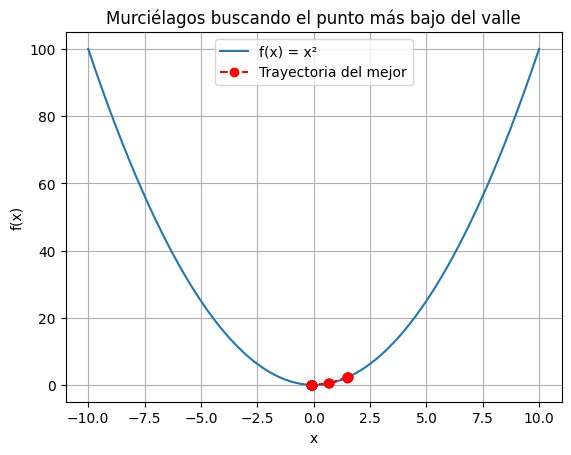

In [24]:
algoritmo = AlgoritmoMurcielago(n_murcielagos=10, n_iteraciones=50, dim=1, lim_inf=-10, lim_sup=10, frecuencia_min=0, frecuencia_max=2, tasa_pulso=0.5, volumen_inicial=1)

mejor_pos, mejor_valor, historial = algoritmo.ejecutar()
print("Mejor posición encontrada (mínimo):", mejor_pos[0])
print("Altura mínima (valor de f(x)):", mejor_valor)

graficar_resultados(historial)